# 8.3 基于自注意力模型的文本语义匹配

**文本语义匹配** {Text Semantic Matching}是一个十分常见的自然语言处理任务。比如在信息检索、问答系统，文本蕴含等任务中都需要用于文本语义匹配的技术。

比如下面三个句子，句子A和句子C的语义更相似，但是如果通过字符串匹配的方式，A和B更容易被判断为相似。

```
A. 什么花一年四季都开？
B. 什么花生一年四季都开？
C. 哪些花可以全年开放？
```

文本语义匹配任务就是希望能从语义上更准确第判断两个句子之间的关系，而不是仅仅通过字符串匹配。
令1表示“相似”，0表示“不相似”，我们希望文本语义匹配模型能够达到这样的效果：
输入A和B两句话，输出为0,；输入A和C两句话，输出为1。

本实践基于自注意力机制来进行文本语义匹配任务。和前两节不同，这里只是用自注意力模型，而不是将自注意力模型叠加在LSTM模型的上面。
这里使用一个非常流行的网络结构Transformer。由于语义匹配是一个分类任务，因此只需要用到Transformer模型的编码器。

基于Transformer编码器的文本语义匹配的整个模型结构如图所示：


<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1b81fa33279a430a972cb30fb5b91143bcd2275f5931437a917a28e0a0e80c88" width="700px"></center>

<br><center>图8.15 基于Transformer编码器的文本语义匹配模型结构</center></br>


我们首先将两个句子“什么花一年四季都开”“哪些花可以全年开放”进行拼接，构建“[CLS]什么花一年四季都开[SEP]哪些花可以全年开放[SEP]”一个句子，其中“[CLS]”表示整个句子的特征，“[SEP]”表示两个句子的分割。这样我们可以将两个句子的匹配问题转换为一个句子的分类问题。

然后，我们将合并后的句子转换成稠密的特征向量（图中的输入编码），然后加入对应的位置编码和分段编码，位置编码和分段编码也是稠密的特征向量，然后输入编码，位置编码分段编码按照位置相加，最终得到每个字符级别的特征表示，字符级别的表示包含了语义信息（输入编码），当前字符的位置信息(位置编码)和句子的信息（分段编码）。然后经过编码器得到多头自注意力机制后的输出，然后取第0个位置的句子向量接入线性层进行分类，得到最终的分类结果"相似"。

## 8.3.1 数据准备

LCQMC是百度知道领域的中文问题匹配数据集，该数据集是从不同领域的用户中提取出来。LCQMC的训练集的数量是	238766条，验证集的大小是4401条，测试集的大小是4401条。其目录结构如下：

```
lcqmc
├── dev.csv  # 验证集
├── test.csv # 测试集
└── train.tsv # 训练集
```

下面看一下其中的一条数据，数据有三部分组成，前两句是文本，表示的是两句话，第三部分是标签，其中1表示的是两文本是相似的，0表示的是两文本是不相似的：

```
什么花一年四季都开      什么花一年四季都是开的  1
```





### 8.3.1.1  数据加载

首先加载数据和词表，利用词表是把句子中的每个中文字符转换成ID。注意由于数据集不同，这里使用的词表跟上面文本分类实验里面的的词表不同。

In [ ]:
from utils.data import load_vocab,load_lcqmc_data
# 加载训练集，验证集，测试集
train_data, dev_data, test_data=load_lcqmc_data('lcqmc')
# 加载词表
word2id_dict = load_vocab()

### 8.3.1.2 构建DataSet

构造一个LCQMCDataset类，LCQMCDataset继承paddle.io.DataSet类，可以逐个数据进行处理。

LCQMCDataset的作用首先就是把文本根据词表转换成ID的形式，对于一个不在词汇表里面的字，默认会将该词用[UNK]代替，由于输入的是两句话，所以需要加入分隔符号[SEP]，并且在起始位置加入[CLS]占位符来表示语义级别的特征表示。


比如对于前面的例子，我们转换成如下的形式：
```
[CLS]什么花一年四季都开[SEP]什么花一年四季都是开的[SEP]
```

然后根据词表将每个词转换成相应的ID表示input_ids。除了用分隔符号[SEP]外，对每个词分别加一维特征segment_ids=0,1来区分该词是来自于哪个句子。0表示该词是来自第一个句子；1表示该词是来自第二个句子。



```
[101, 784, 720, 5709, 671, 2399, 1724, 2108, 6963, 2458, 102, 784, 720, 5709, 671, 2399, 1724, 2108, 6963, 3221, 2458, 4638, 102]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
```

In [ ]:
from paddle.io import Dataset

class LCQMCDataset(Dataset):
    def __init__(self, data, word2id_dict):
        # 词表
        self.word2id_dict = word2id_dict
        # 数据
        self.examples = data
        # ['CLS']的id，占位符
        self.cls_id = self.word2id_dict['[CLS]']
        # ['SEP']的id，句子的分隔
        self.sep_id = self.word2id_dict['[SEP]']

    def __getitem__(self, idx):
        # 返回单条样本
        example = self.examples[idx]
        text, segment, label = self.words_to_id(example)
        return text, segment, label

    def __len__(self):
        # 返回样本的个数
        return len(self.examples)

    def words_to_id(self, example):
        text_a, text_b, label = example
        # text_a 转换成id的形式
        input_ids_a = [self.word2id_dict[item] if item in self.word2id_dict else self.word2id_dict['[UNK]'] for item in text_a]
        # text_b 转换成id的形式
        input_ids_b = [self.word2id_dict[item] if item in self.word2id_dict else self.word2id_dict['[UNK]'] for item in text_b]
        # 加入[CLS],[SEP]
        input_ids = [self.cls_id]+ input_ids_a + [self.sep_id] + input_ids_b + [self.sep_id]
        # 对句子text_a,text_b做id的区分，进行的分隔
        segment_ids = [0]*(len(input_ids_a)+2)+[1]*(len(input_ids_b)+1)
        return input_ids, segment_ids, int(label)

    @property
    def label_list(self):
        # 0表示不相似，1表示相似
        return ['0', '1']

# 加载训练集
train_dataset = LCQMCDataset(train_data,word2id_dict)
# 加载验证集
dev_dataset = LCQMCDataset(dev_data,word2id_dict)
# 加载测试集
test_dataset = LCQMCDataset(test_data,word2id_dict)


### 8.3.1.3 构建Dataloader

构建DataLoader的目的是组装成小批量的数据，在组装小批量的数据之前，首先对文本数据转为ID表示，然后把数据用[PAD]进行对齐。这里我们将[PAD]的ID设为0，因此补齐操作就是把ID序列用0对齐到最大长度。

对数据进行统一格式化后，使用DataLoader组装成小批次的数据迭代器。

In [ ]:
from paddle.io import DataLoader
import paddle

def collate_fn(batch_data, pad_val=0, max_seq_len=512):
    input_ids, segment_ids, labels = [], [], []
    max_len = 0
    # print(batch_data)
    for example in batch_data:
        input_id, segment_id, label = example
        # 对数据序列进行截断
        input_ids.append(input_id[:max_seq_len])
        segment_ids.append(segment_id[:max_seq_len])
        labels.append(label)
        # 保存序列最大长度
        max_len = max(max_len, len(input_id))
    # 对数据序列进行填充至最大长度
    for i in range(len(labels)):
        input_ids[i] = input_ids[i]+[pad_val] * (max_len - len(input_ids[i]))
        segment_ids[i] = segment_ids[i]+[pad_val] * (max_len - len(segment_ids[i]))
    return (
        paddle.to_tensor(input_ids),
        paddle.to_tensor(segment_ids),
    ), paddle.to_tensor(labels)

batch_size = 32
# 构建训练集,验证集，测试集的dataloader
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False
)
dev_loader = DataLoader(
    dev_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False
)

# 打印输出一条mini-batch的数据
for idx, item in enumerate(train_loader):
    if idx == 0:
        print(item)
        break

[[Tensor(shape=[32, 52], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [[101 , 1599, 3614, ..., 0   , 0   , 0   ],
        [101 , 2769, 2797, ..., 0   , 0   , 0   ],
        [101 , 1920, 2157, ..., 0   , 0   , 0   ],
        ...,
        [101 , 1453, 3345, ..., 0   , 0   , 0   ],
        [101 , 3299, 1159, ..., 5023, 2521, 102 ],
        [101 , 3118, 802 , ..., 0   , 0   , 0   ]]), Tensor(shape=[32, 52], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0]])], Tensor(shape=[32], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 1])]


从上面的输出可以看到，第一个张量的形状是[32,52],其中分别是样本数量和句子长度。如果句子本身的长度不够52个字符，则会补0处理；第二个张量的输出的维度是[32,52]，表示的是句子的编码，可以看到两个句子被编码成了只包含0，1的向量；最后一个张量是标签的编码，维度是32，表示有32个标签，1表示的是该句子是相似的，0表示的是该句子是不相似的。

## 8.3.2  模型构建

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/9256f30d032045f2a1fec3c44bd4e7747e4d331a04774d05938db566896aee96" width="700px"></center>

<br><center>图8.16 文本语义匹配模型结构</center></br>



如图8.15所示，基于Transformer编码器的语义匹配模型由以下几个部分组成：

 1） 嵌入层：用于输入的句子中的词语的向量化表示，由于语义匹配任务的输入是两句文本，所以需要分段编码对每个句子进行向量化表示，最后还需要对句子中词语的位置进行向量化表示，即位置编码。
 
 2） Transformer组块：使用Transformer的编码组块来计算深层次的特征表示。
 
 3） 线性层：输出层，得到该句子的分类。线性层的输入是第一个位置[CLS]的输出向量。



### 8.3.2.1 嵌入层

嵌入层是将输入的文字序列转换为向量序列。这里除了之前的词向量外，我们还需要引入两种编码。


1） **位置编码**{Position Embeddings}：自注意力模块本身无法感知序列的输入顺序信息，即一个词对其它词的影响和它们之间的距离没有关系。因此，自注意力模块通常需要和卷积网络、循环网络一起组合使用。如果单独使用自注意力模块，就需要对其输入表示补充位置信息。位置编码主要是把字的位置信息向量化。

2） **分段编码** {Segment Embeddings}：由于本实践中处理的输入序列是由两个句子拼接而成。为了区分每个词来自于哪个句子，对每个词增加一个0,1分段标记，表示该词是第0或1个句子。分段编码是将分段标记也向量化。

下面我们分别介绍这几种编码。

**（1）输入编码**

**输入编码** {Input Embeddings}把输入的词转化成向量的形式。输入编码看作是一个查表的操作，对于每个单词，要将这些符号转换为向量形式．一种简单的转换方法是通过一个**嵌入表** {Embedding Lookup Table}来将每个符号直接映射成向量表示．这里使用飞桨的paddle.nn.Embedding来根据输入序列中的id信息从嵌入矩阵中查询对应嵌入向量。

```
class paddle.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, sparse=False, weight_attr=None, name=None)
```

`paddle.nn.Embedding`会根据`[num_embeddings, embedding_dim]`自动构造一个二维嵌入矩阵。如果配置了`padding_idx`，那么在训练过程中遇到此id时，其参数及对应的梯度将会以0进行填充。

在Transformer的输入编码的实现中，初始化使用的是随机正态分布，均值为0，标准差为$\frac{1}{\sqrt{\textrm{emb\_size}}}$，$\textrm{emb\_size}$表示的是词向量的维度。所有的向量都乘以了$\sqrt{\textrm{emb\_size}}$。代码实现如下：


In [ ]:
import paddle
import paddle.nn as nn

class WordEmbedding(nn.Layer):
    def __init__(self, vocab_size, emb_size, padding_idx=0):
        super(WordEmbedding, self).__init__()
        # Embedding的维度
        self.emb_size = emb_size
        # 使用随机正态（高斯）分布初始化 embedding
        self.word_embedding = nn.Embedding(vocab_size, emb_size,
            padding_idx=padding_idx, weight_attr=paddle.ParamAttr(
                initializer=nn.initializer.Normal(0.0, emb_size ** -0.5) ), )

    def forward(self, word):
        word_emb = self.emb_size ** 0.5 * self.word_embedding(word)
        return word_emb

paddle.seed(2021)
# 构造一个输入
X = paddle.to_tensor([1, 0, 2])
# 表示构造的输入编码的词汇表的大小是10，每个词的维度是4
word_embed = WordEmbedding(10, 4)
print("输入编码为： {}".format(X.numpy()))
word_out = word_embed(X)
print("输出为： {}".format(word_out.numpy()))

W0714 14:06:33.794049   204 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0714 14:06:33.800398   204 device_context.cc:465] device: 0, cuDNN Version: 8.2.


输入编码为： [1 0 2]
输出为： [[-0.7112208  -0.35037443  0.7261958  -0.31876457]
 [ 0.          0.          0.          0.        ]
 [-0.43065292  0.35489145  1.9781216   0.12072387]]


**（2）分段编码**

分段编码的作用是使得模型能够接受句子对进行训练，用编码的方法使得模型能够区分两个句子。这里指定0来标记句子0，用1标记句子1。对于句子0，创建标记为0的向量，对于句子1，创建标记为1的向量。分段编码的实现跟输入编码类似，不同在于词表大小为2。

以下面的句子为例，

```
什么花一年四季都开      什么花一年四季都是开的
```
我们的分段标记为：

```
0 0 0 0 0 0 0 0 0    1 1 1 1 1 1 1 1 1 1 1
```

下面我们实现分段编码，将分段标记映射为向量表示。分段编码的维度和输入编码一样。
代码实现如下：

In [ ]:
class SegmentEmbedding(nn.Layer):
    def __init__(self, vocab_size, emb_size):
        super(SegmentEmbedding, self).__init__()
        # Embedding的维度
        self.emb_size = emb_size
        # 分段编码
        self.seg_embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=emb_size
        )

    def forward(self, word):
        seg_embedding = self.seg_embedding(word)
        return seg_embedding

paddle.seed(2021)
# 构造一个输入,0表示第0句的token，1表示第1句的token
X = paddle.to_tensor([0, 0, 1, 1])
word_embed = SegmentEmbedding(2, 4)
print("输入编码为： {}".format(X.numpy()))
word_out = word_embed(X)
print("输出为： {}".format(word_out.numpy()))

输入编码为： [0 0 1 1]
输出为： [[-0.90914416  0.7011595  -0.33276933  0.892782  ]
 [-0.90914416  0.7011595  -0.33276933  0.892782  ]
 [-0.52305263 -0.2739423   0.5322813  -0.25009495]
 [-0.52305263 -0.2739423   0.5322813  -0.25009495]]


**（3）位置编码**

为了使得自注意力模块可以感知序列的顺序信息，Transformer给编码层输入添加了一个额外的位置编码。
位置编码的目的是在让自注意力模块在计算时引入词之间的距离信息。

下面我们用三角函数（正弦或者余弦）来编码位置信息。假设位置编码的维度为$D$，则其中每一维的值的计算如下：
$$
PE(pos,2i) =\sin\left(\frac{t}{10000^{{2i/D}}}\right),\\
PE(pos,2i+1) =\cos\left(\frac{t}{10000^{{2i/D}}}\right),
$$
其中$t$是指当前词在句子中的位置，$0 \leqslant i\leqslant \frac{D}{2}$为编码向量的维数。在偶数维，使用正弦编码；在奇数维，使用余弦编码。

In [ ]:
import numpy as np
import paddle

# position_size 为句子划分成字符或者词的长度，hidden_size为词向量的维度。
def get_sinusoid_encoding(position_size, hidden_size):
    """位置编码 """

    def cal_angle(pos, hidden_idx):
        # 公式里的 i = hid_idx // 2
        return pos / np.power(10000, 2 * (hidden_idx // 2) / hidden_size)

    def get_posi_angle_vec(pos):
        return [cal_angle(pos, hidden_j) for hidden_j in range(hidden_size)]

    sinusoid = np.array([get_posi_angle_vec(pos_i) for pos_i in range(position_size)])
    # dim 2i  偶数正弦
    # 从0开始，每隔2间隔求正弦值
    sinusoid[:, 0::2] = np.sin(sinusoid[:, 0::2])
    # dim 2i 1  奇数余弦
    # 从1开始，每隔2间隔取余弦
    sinusoid[:, 1::2] = np.cos(sinusoid[:, 1::2])
    # position_size × hidden_size  得到每一个词的位置向量
    return sinusoid.astype("float32")

paddle.seed(2021)
position_size = 4
hidden_size = 3
encoding_vec=get_sinusoid_encoding(position_size, hidden_size)
print("位置编码的输出为：{}".format(encoding_vec))

位置编码的输出为：[[ 0.          1.          0.        ]
 [ 0.84147096  0.5403023   0.00215443]
 [ 0.9092974  -0.41614684  0.00430886]
 [ 0.14112    -0.9899925   0.00646326]]


利用上面的三角函数来实现位置编码，代码如下：

In [ ]:
class PositionalEmbedding(nn.Layer):
    def __init__(self, max_length,emb_size):
        super(PositionalEmbedding, self).__init__()
        self.emb_size = emb_size
        # 使用三角函数初始化Embedding
        self.pos_encoder = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=self.emb_size,
            weight_attr=paddle.ParamAttr(
                initializer=paddle.nn.initializer.Assign(
                    get_sinusoid_encoding(max_length, self.emb_size))))
    
    def forward(self, pos):
        pos_emb = self.pos_encoder(pos)
        # 关闭位置编码的梯度更新
        pos_emb.stop_gradient = True
        return pos_emb

paddle.seed(2021)
out = paddle.randint(low=0, high=5, shape=[3])
print('输入向量为：{}'.format(out.numpy()))
pos_embed=PositionalEmbedding(4,5)
pos_out=pos_embed(out)
print('位置编码的输出为： {}'.format(pos_out.numpy()))

输入向量为：[1 0 1]
位置编码的输出为： [[8.4147096e-01 5.4030228e-01 2.5116222e-02 9.9968451e-01 6.3095731e-04]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [8.4147096e-01 5.4030228e-01 2.5116222e-02 9.9968451e-01 6.3095731e-04]]


为了对使用三角函数的位置编码有个直观了解，这里对三角函数初始化的值进行可视化，代码如下：

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_curve(size,y):
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(size), y[0, :, 4:5].numpy(),color='#e4007f',linestyle='-')
    plt.plot(np.arange(size), y[0, :, 5:6].numpy(),color='#f19ec2',linestyle='--')
    plt.plot(np.arange(size), y[0, :, 6:7].numpy(),color='#000000',linestyle='-.')
    plt.legend(["dim %d"%p for p in [4,5,6]], fontsize='large')
    plt.savefig('att-vis2.pdf')

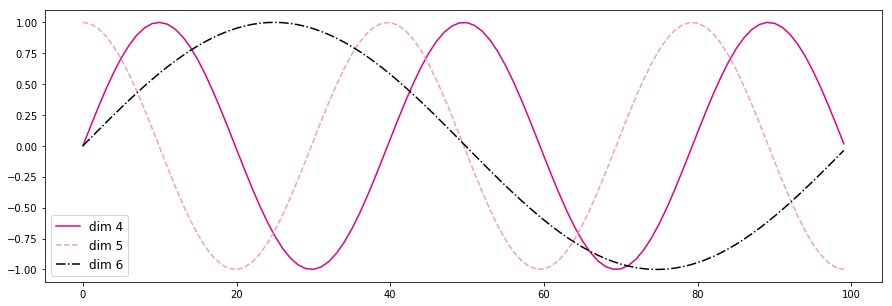

In [ ]:
model = PositionalEmbedding(emb_size=20, max_length=5000)
# 生成0~99这100个数，表示0~99这100个位置
size = 100
X= paddle.arange((size)).reshape([1,size])
# 对这100个位置进行编码，得到每个位置的向量表示
# y: [1,100,20]
y = model(X)
# 把这100个位置的第4，5，6列的数据可视化出来
plot_curve(size,y)

可以看到，位置编码本质上是一个和位置相关的正弦曲线，每个维度的正弦波的频率和大小不一样，取值范围在$[-1,1]$之间。

********
基于三角函数的位置编码，计算任意两个位置的点积，观察是否可以推断出两个位置的距离信息？
********

********
总结基于三角函数的位置编码的优缺点，并思考更好的位置编码方式
********

**（4）嵌入层汇总**

最后，我们把输入编码，分段编码和位置编码进行相加，并对加和后的向量进行层规范化和暂退操作，代码如下：

In [ ]:
class TransformerEmbeddings(nn.Layer):
    """
    包括输入编码，分段编码，位置编码
    """
    def __init__(
        self,
        vocab_size,
        hidden_size=768,
        hidden_dropout_prob=0.1,
        position_size=512,
        segment_size=2,
    ):
        super(TransformerEmbeddings, self).__init__()
        # 输入编码向量
        self.word_embeddings = WordEmbedding(vocab_size, hidden_size)
        # 位置编码向量
        self.position_embeddings = PositionalEmbedding(position_size, hidden_size)
        # 分段编码
        self.segment_embeddings = SegmentEmbedding(segment_size, hidden_size)
        # 层规范化
        self.layer_norm = nn.LayerNorm(hidden_size)
        # Dropout操作
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, input_ids, segment_ids = None, position_ids = None):
        if position_ids is None:
            # 初始化全1的向量，比如[1,1,1,1]
            ones = paddle.ones_like(input_ids, dtype="int64")
            # 累加输入,求出序列前K个的长度,比如[1,2,3,4]
            seq_length = paddle.cumsum(ones, axis=-1)
            # position id的形式： 比如[0,1,2,3]
            position_ids = seq_length - ones
            position_ids.stop_gradient = True
        # 输入编码
        input_embedings = self.word_embeddings(input_ids)
        # 分段编码
        segment_embeddings = self.segment_embeddings(segment_ids)
        # 位置编码
        position_embeddings = self.position_embeddings(position_ids)
        # 输入张量, 分段张量，位置张量进行叠加
        embeddings = input_embedings + segment_embeddings + position_embeddings
        # 层规范化
        embeddings = self.layer_norm(embeddings)
        # Dropout
        embeddings = self.dropout(embeddings)
        return embeddings

### 8.3.2.2 Transformer组块

Transformer编码器由多个Transformer组块叠加而成。一个Transformer组块的结构如图8.17所示，共包含四个模块：多头注意力层、加与规范化层、前馈层、加与规范化层。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/0ec699f6bdb04e7db58c18be2bbfd41d7b8def8ac9a847ccb7ca75b6726ed538" width="500px"></center>

<br><center>图8.17 Transformer组块结构</center></br>


下面我们分别实现这几个层。

**多头自注意力层**

多头自注意力直接使用在第8.2.1.3中定义的`MultiHeadSelfAttention`算子。

**加与规范层**

**加与规范**{Add\&Norm}层主要功能是加入**残差连接**{Residual Connection}与**层规范化**{Layer Normalization}两个组件，使得网络可以更好地训练。残差连接有助于避免深度网络中的梯度消失问题，而层规范化保证数据特征分布的稳定性，网络的收敛性更好。

在Transformer组块，有两个地方使用了加与规范层，这里是第一次使用。

假设多头自注意力层的输入和输出分别为$\mathbf X\in \mathbb{R}^{B \times L \times D}$和$\mathbf H\in \mathbb{R}^{B \times L \times D}$，加与规范层可以写为
$$
\mathbf H=\mathrm{LN}(\mathbf H+\mathbf X),
$$

$\mathrm{LN(\cdot)}$表示层规范化操作。

加与规范层的实现如下，这里还对$\mathbf H$进行了Dropout操作。


In [ ]:
import paddle.nn as nn

class AddNorm(nn.Layer):
    """加与规范化"""
    def __init__(self, size, dropout_rate):
        super(AddNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X, H):
        """
            X：表示被包裹的非线性层的输入
            H：表示被包裹的非线性层的输出
        """
        H = X + self.dropout(H)
        return self.layer_norm(H)

  在Transformer的具体实现中，层规范化操作的位置有两种，分别称为PreNorm和PostNorm。假设要给非线性$\mathbf H=f(\mathbf X)$加上加与规范层，则PreNorm和PostNorm分别定义为：
$$
  \mathrm{PreNorm} : \mathbf H=\mathbf X + f(\mathrm{LN}(\mathbf X) ) \\
  \mathrm{PostNorm} : \mathbf H=\mathrm{LN} (f(\mathbf X)+\mathbf X))
$$
很多研究表明， PreNorm更容易训练，但PostNorm上限更佳。请分析其背后的原因。


**逐位前馈层**

逐位前馈层（Position-wised Feed Forward Networks，FFN）是两层全连接神经网络，使用ReLU激活函数。将每个位置的特征表示进行融合变换，类似于更复杂的核大小为1的“卷积”。

假设逐位前馈层的输入为张量$\mathbf H \in \mathbb{R}^{B \times L \times D}$，其中$B,L,D$分别表示输入张量的批量大小、序列长度和特征维度，则前馈层的计算公式为：
$$
\mathrm{FNN}(\mathbf H)=\max(0,\mathbf H\mathbf W_1+\mathbf b_1)\mathbf W_2+\mathbf b_2,
$$
其中$\mathbf W_{1} \in \mathbb{R}^{ D \times D'}$，$\mathbf W_{2} \in \mathbb{R}^{D'\times D}$，$\mathbf b_{1} \in \mathbb{R}^{D'}$，$\mathbf b_{2} \in \mathbb{R}^{D}$是可学习的参数，


逐位前馈层的代码实现如下：

In [ ]:
class PositionwiseFFN(nn.Layer):
    """逐位前馈层"""
    def __init__(self, input_size, mid_size, dropout=0.1):
        super(PositionwiseFFN, self).__init__()
        self.W_1 = nn.Linear(input_size, mid_size)
        self.W_2 = nn.Linear(mid_size, input_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        return self.W_2(self.dropout(F.relu(self.W_1(X))))

**加与规范层**

逐位前馈层之后是第二个加与规范层，实现和第8.3.2.2
节中一样，这里就不再重复。

**Transformer组块汇总**

汇总上面的的4个模块，构建Transformer组块。

In [ ]:
class TransformerBlock(nn.Layer):
    def __init__(
        self,
        input_size,
        head_num,
        ffn_size,
        dropout=0.1,
        attn_dropout=None,
        act_dropout=None,
    ):
        super(TransformerBlock, self).__init__()
        # 输入数据的维度
        self.input_size = input_size
        # 多头自注意力多头的个数
        self.head_num = head_num
        # 逐位前馈层的大小
        self.ffn_size = ffn_size
        # 加与规范化里面 Dropout的参数
        self.dropout = dropout
        # 多头注意力里面的 Dropout参数
        self.attn_dropout = dropout if attn_dropout is None else attn_dropout
        # 逐位前馈层里面的 Dropout参数
        self.act_dropout = dropout if act_dropout is None else act_dropout
        # 多头自注意力机制
        self.multi_head_attention = nn.MultiHeadAttention(
            self.input_size,
            self.head_num,
            dropout=self.attn_dropout,
            need_weights=True,
        )
        # 逐位前馈层
        self.ffn = PositionwiseFFN(self.input_size, self.ffn_size, self.act_dropout)
        # 加与规范化
        self.addnorm = AddNorm(self.input_size, self.dropout)

    def forward(self, X, src_mask=None):
        # 多头注意力
        X_atten, atten_weights = self.multi_head_attention(X, attn_mask=src_mask)
        # 加与规范化
        X = self.addnorm(X, X_atten)
        # 前馈层
        X_ffn = self.ffn(X)
        # 加与规范化
        X = self.addnorm(X, X_ffn)
        return X, atten_weights

### 8.3.2.3 模型汇总

接下来，我们将嵌入层、Transformer组件、线性输出层进行组合，构建Transformer模型。

Transformer模型主要是输入编码，分段编码，位置编码，Transformer编码器和最后的全连接分类器，代码实现如下：

In [ ]:
class Model_Transformer(nn.Layer):
    def __init__(
        self,
        vocab_size,
        n_block=2,
        hidden_size=768,
        heads_num=12,
        intermediate_size=3072,
        hidden_dropout=0.1,
        attention_dropout=0.1,
        act_dropout=0,
        position_size=512,
        num_classes=2,
        padding_idx=0,
    ):
        super(Model_Transformer, self).__init__()
        # 词表大小
        self.vocab_size = vocab_size
        # Transformer的编码器的数目
        self.n_block = n_block
        # 每个词映射成稠密向量的维度
        self.hidden_size = hidden_size
        # 多头注意力的个数
        self.heads_num = heads_num
        # 逐位前馈层的的维度
        self.intermediate_size = intermediate_size
        # Embedding层的 Dropout
        self.hidden_dropout = hidden_dropout
        # 多头注意力的dropout的 dropout参数
        self.attention_dropout = attention_dropout
        # 位置编码的大小 position_size
        self.position_size = position_size
        # 类别数
        self.num_classes = num_classes
        # 逐位前馈层的dropout
        self.act_dropout = act_dropout
        # [PAD]字符的ID
        self.padding_idx = padding_idx
        # 实例化输入编码，分段编码和位置编码
        self.embeddings = TransformerEmbeddings(
            self.vocab_size, self.hidden_size, self.hidden_dropout, self.position_size )
        # 实例化Transformer的编码器
        self.layers = nn.LayerList([])
        for i in range(n_block):
            encoder_layer = TransformerBlock(
                hidden_size,
                heads_num,
                intermediate_size,
                dropout=hidden_dropout,
                attn_dropout=attention_dropout,
                act_dropout=act_dropout,
            )
            self.layers.append(encoder_layer)
        # 全连接层
        self.dense = nn.Linear(hidden_size, hidden_size)
        # 双曲正切激活函数
        self.activation = nn.Tanh()
        # 最后一层分类器
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, inputs, position_ids=None, attention_mask=None):
        input_ids, segment_ids = inputs
        # 构建Mask矩阵，把Pad的位置即input_ids中为0的位置设置为True,非0的位置设置为False
        if attention_mask is None:
            attention_mask = paddle.unsqueeze(
                (input_ids == self.padding_idx).astype("float32") * -1e9, axis=[1, 2] )
        # 抽取特征向量
        embedding_output = self.embeddings(
            input_ids=input_ids, position_ids=position_ids, segment_ids=segment_ids )
        sequence_output = embedding_output
        self._attention_weights = []
        # Transformer的输出和注意力权重的输出
        for i, encoder_layer in enumerate(self.layers):
            sequence_output, atten_weights = encoder_layer(
                sequence_output, src_mask=attention_mask )
            self._attention_weights.append(atten_weights)
        # 选择第0个位置的向量作为句向量
        first_token_tensor = sequence_output[:, 0]
        # 输出层
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        # 句子级别的输出经过分类器
        logits = self.classifier(pooled_output)
        return logits

    @property
    def attention_weights(self):
        return self._attention_weights

在模型构建完成之后，我们使用RunnerV3类来进行模型的训练、评价、预测等过程。

## 8.3.3 模型训练

模型的训练配置的设置，包括一些超参数、优化器、损失函数等等，训练过程：模型的训练从Dataloader中取数据进行前向反向训练，每隔100个step输出一次日志，每隔500个step在验证集合上计算一次准确率。训练3个回合，并保存在验证集上最佳准确率的模型。

In [15]:
from nndl import Accuracy, RunnerV3
import os 
import paddle.nn.functional as F

paddle.seed(2021)
heads_num = 4
epochs = 3
vocab_size=21128
num_classes= 2
padding_idx=word2id_dict['[PAD]']
# 注意力多头的数目
# 交叉熵损失
criterion = nn.CrossEntropyLoss()
# 评估的时候采用准确率指标
metric = Accuracy()
# Transformer的分类模型
model = Model_Transformer(
    vocab_size=vocab_size,
    n_block=1,
    num_classes=num_classes,
    heads_num=heads_num,
    padding_idx=padding_idx,
)

# 排除所有的偏置和LayerNorm的参数
decay_params = [
    p.name for n, p in model.named_parameters()
    if not any(nd in n for nd in ["bias", "norm"])
]

# 定义 Optimizer
optimizer = paddle.optimizer.AdamW(
    learning_rate=5E-5,
    parameters=model.parameters(),
    weight_decay=0.0,
    apply_decay_param_fun=lambda x: x in decay_params)

runner = RunnerV3(model, optimizer, criterion, metric)
save_path = "./checkpoint/model_best.pdparams"
runner.train(
    train_loader,
    dev_loader,
    num_epochs=epochs,
    log_steps=100,
    eval_steps=500,
    save_path=save_path,
)

[Train] epoch: 0/3, step: 0/22386, loss: 1.41052
[Train] epoch: 0/3, step: 100/22386, loss: 0.59608
[Train] epoch: 0/3, step: 200/22386, loss: 0.67516
[Train] epoch: 0/3, step: 300/22386, loss: 0.57150
[Train] epoch: 0/3, step: 400/22386, loss: 0.63550
[Train] epoch: 0/3, step: 500/22386, loss: 0.61048
[Evaluate]  dev score: 0.53647, dev loss: 0.72411
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.53647
[Train] epoch: 0/3, step: 600/22386, loss: 0.56387
[Train] epoch: 0/3, step: 700/22386, loss: 0.61008
[Train] epoch: 0/3, step: 800/22386, loss: 0.58331
[Train] epoch: 0/3, step: 900/22386, loss: 0.64518
[Train] epoch: 0/3, step: 1000/22386, loss: 0.60527
[Evaluate]  dev score: 0.54760, dev loss: 0.73040
[Evaluate] best accuracy performence has been updated: 0.53647 --> 0.54760
[Train] epoch: 0/3, step: 1100/22386, loss: 0.58656
[Train] epoch: 0/3, step: 1200/22386, loss: 0.84857
[Train] epoch: 0/3, step: 1300/22386, loss: 0.62063
[Train] epoch: 0/3, step: 1400/223

KeyboardInterrupt: 

In [ ]:
from nndl import plot
plot(runner, 'att-loss-acc3.pdf')

## 8.3.4 模型评价

模型评价使用test\_loader进行评价，并输出准确率。

In [ ]:
model_path = "checkpoint/model_best.pdparams"
runner.load_model(model_path)
accuracy, _ =  runner.evaluate(test_loader)
print(f"Evaluate on test set, Accuracy: {accuracy:.5f}")

********
叠加多层的Transformer组块，观察对比实验效果。
********

## 8.3.5 模型预测

从测试的数据集中取出一条数据，然后用word2id\_dict进行编码变成ID的形式，然后放到模型里面进行预测输出，代码实现如下：

In [16]:
model_path = "checkpoint_base/model_best.pdparams"
runner.load_model(model_path)
text_a = "电脑怎么录像？"
text_b = "如何在计算机上录视频"
# [CLS]转换成id
cls_id = word2id_dict["[CLS]"]
# [SEP]转换成id
sep_id = word2id_dict["[SEP]"]
# text_a转换成id的形式
input_ids_a = [
    word2id_dict[item] if item in word2id_dict else word2id_dict["[UNK]"]
    for item in text_a
]
# text_b转换成id的形式
input_ids_b = [
    word2id_dict[item] if item in word2id_dict else word2id_dict["[UNK]"]
    for item in text_b
]
# 两个句子拼接成id的形式
input_ids = [cls_id]+ input_ids_a + [sep_id] + input_ids_b + [sep_id]
# 分段id的形式
segment_ids = [0]*(len(input_ids_a)+2)+[1]*(len(input_ids_b)+1)
# 转换成Tensor张量
input_ids = paddle.to_tensor([input_ids])
segment_ids = paddle.to_tensor([segment_ids])
inputs = [input_ids, segment_ids]
# 模型预测
logits = runner.predict(inputs)
# 取概率值最大的索引
label_id = paddle.argmax(logits, axis=1).numpy()[0]
print('预测的label标签 {}'.format(label_id))

预测的label标签 1


可以看到预测的标签是1，表明这两句话是相似的，这说明预测的结果是正确的。

## 8.3.6  注意力可视化

为了验证注意力机制学到了什么，本节把注意力机制的权重提取出来，然后进行可视化分析。

In [17]:
# 首先加载模型
model_path='checkpoint_base/model_best.pdparams'
loaded_dict = paddle.load(model_path)
model.load_dict(loaded_dict)
model.eval()
# 输入一条样本
text_a = '电脑怎么录像？'
text_b = '如何在计算机上录视频'
texts = ['CLS']+list(text_a)+['SEP']+list(text_b)+['SEP']
# text_a和text_b分别转换成id的形式
input_ids_a = [
    word2id_dict[item] if item in word2id_dict else word2id_dict["[UNK]"]
    for item in text_a
]
input_ids_b = [
    word2id_dict[item] if item in word2id_dict else word2id_dict["[UNK]"]
    for item in text_b
]
# text_a和text_b拼接
input_ids = [cls_id]+ input_ids_a + [sep_id] + input_ids_b + [sep_id]
# 分段编码的id的形式
segment_ids = [0]*(len(input_ids_a)+2)+[1]*(len(input_ids_b)+1)
print("输入的文本：{}".format(texts))
print("输入的id形式：{}".format(input_ids))
# 转换成Tensor
input_ids = paddle.to_tensor([input_ids])
segment_ids = paddle.to_tensor([segment_ids])
inputs = [input_ids, segment_ids]
# 评估模式
model.eval()
# 模型预测
with paddle.no_grad():
    pooled_output = model(inputs)
# 获取多头注意力权重
atten_weights = model.attention_weights[0].numpy()

输入的文本：['CLS', '电', '脑', '怎', '么', '录', '像', '？', 'SEP', '如', '何', '在', '计', '算', '机', '上', '录', '视', '频', 'SEP']
输入的id形式：[101, 4510, 5554, 2582, 720, 2497, 1008, 8043, 102, 1963, 862, 1762, 6369, 5050, 3322, 677, 2497, 6228, 7574, 102]


将注意力权重atten\_weights进行可视化。

<Figure size 432x288 with 0 Axes>

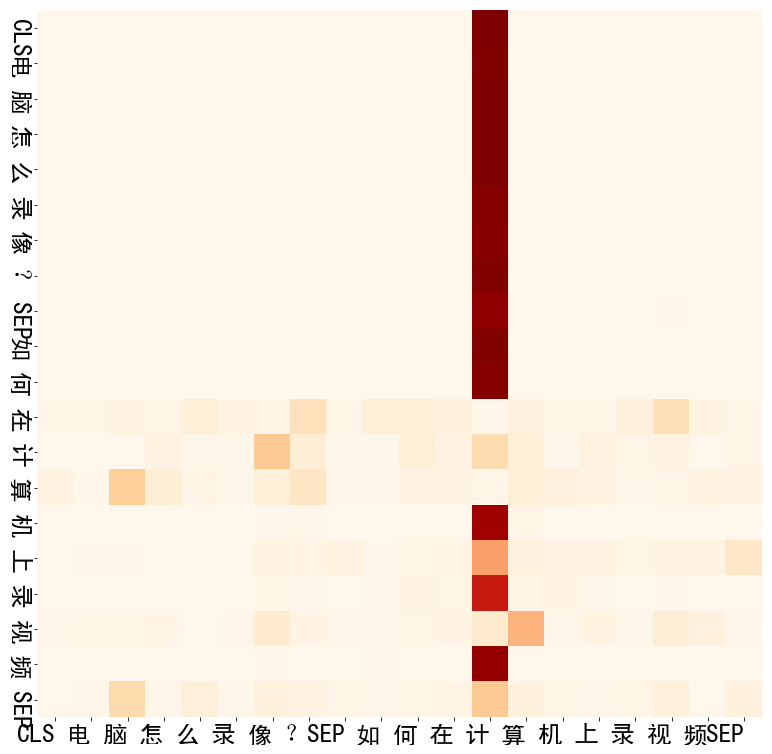

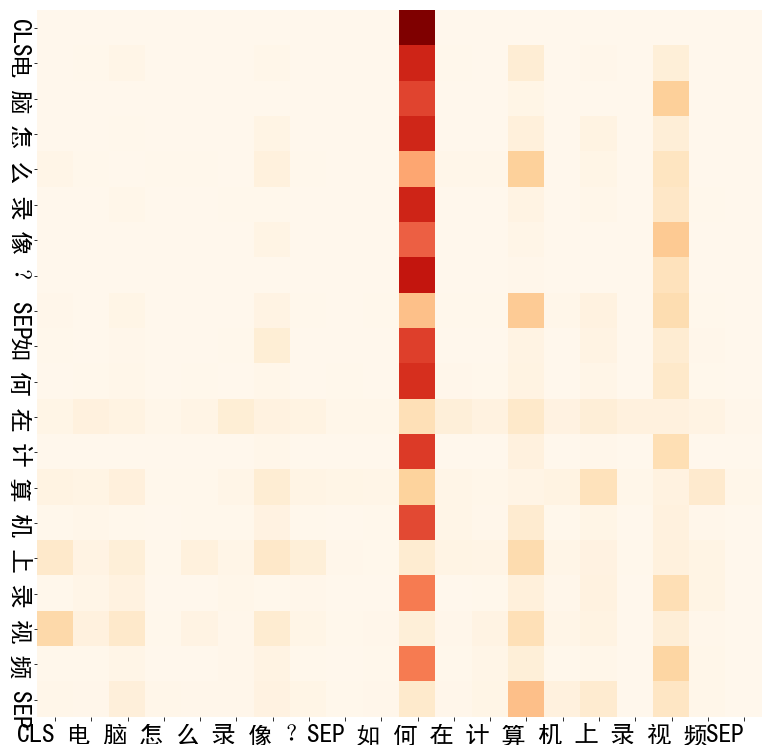

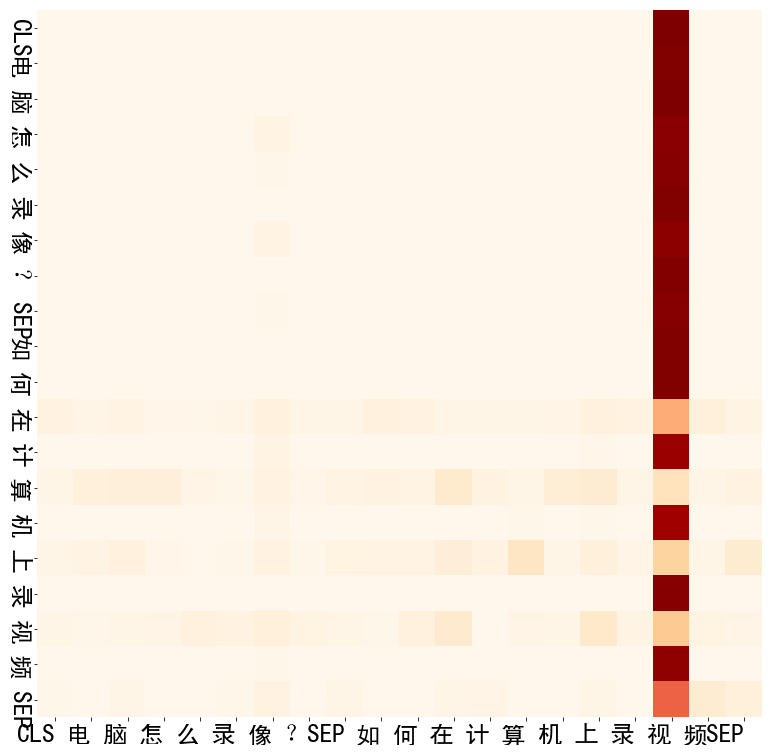

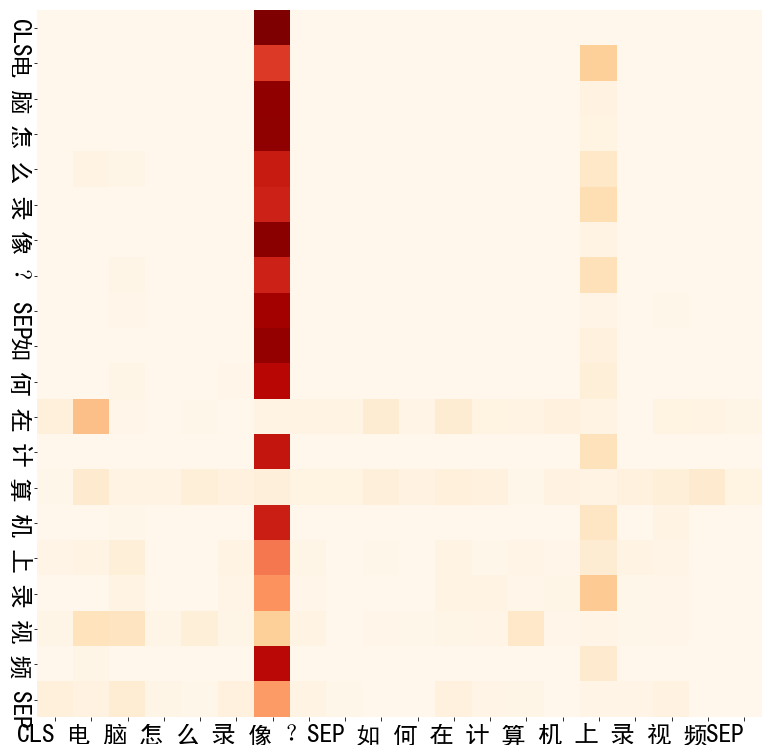

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import pandas as pd

data_attention = atten_weights[0]
plt.clf()
font_size = 25
font = FontProperties(fname="simhei.ttf", size=font_size)
# 可视化其中的head，总共heads_num 个head
for head in range(heads_num):
    data = pd.DataFrame(data=data_attention[head], index=texts, columns=texts)
    f, ax = plt.subplots(figsize=(13, 13))
    # 使用heatmap可视化
    sns.heatmap(data, ax=ax, cmap="OrRd", cbar=False)
    # y轴旋转270度
    label_y = ax.get_yticklabels()
    plt.setp(label_y, rotation=270, horizontalalignment="right", fontproperties=font)
    # x轴旋转0度
    label_x = ax.get_xticklabels()
    plt.setp(label_x, rotation=0, horizontalalignment="right", fontproperties=font)
    plt.savefig('att-vis3_{}.pdf'.format(head))
    plt.show()


上图所示，颜色越深，表示的权重越高，可以看到第一个位置的[CLS]跟“计”，“视”，“像”，“何”的关系比较大。另外第二句话里面的“计”与“视"跟第一句话里面的“录像"，“电脑"等词关系比较大。对于同一个句子内，“视"和“频"的关系很大等等。

********
请可视化自注意力头，挖掘出更多更有意思的信息。
********

# 8.4 基于框架API实现文本语义匹配

## 8.4.1【框架API】文本语义匹配

### 8.4.1.1 模型构建

前面的章节使用了自己实现的TransformerBlock来构建文本语义匹配模型，在实际使用过程中不需要自己实现，直接使用框架的API即可，下面我们来实现一下，对比一下结果。

In [ ]:
class Model_Transformer_v1(nn.Layer):
    def __init__(
        self,
        vocab_size,
        n_block=1,
        hidden_size=768,
        heads_num=12,
        intermediate_size=3072,
        hidden_dropout=0.1,
        attention_dropout=0.1,
        act_dropout=0,
        position_size=512,
        num_classes=2,
        padding_idx=0,
    ):
        super(Model_Transformer_v1, self).__init__()
        # 词表大小
        self.vocab_size = vocab_size
        # Transformer的编码器的数目
        self.n_block = n_block
        # 每个词映射成稠密向量的维度
        self.hidden_size = hidden_size
        # 多头注意力的个数
        self.heads_num = heads_num
        # 逐位前馈层的的维度
        self.intermediate_size = intermediate_size
        # Embedding层的 Dropout
        self.hidden_dropout = hidden_dropout
        # 多头注意力的dropout的 dropout参数
        self.attention_dropout = attention_dropout
        # 位置编码的大小 position_size
        self.position_size = position_size
        # 类别数
        self.num_classes = num_classes
        # 逐位前馈层的dropout
        self.act_dropout = act_dropout
        # [PAD]字符的ID
        self.padding_idx = padding_idx
        # 实例化输入编码，分段编码和位置编码
        self.embeddings = TransformerEmbeddings(
            self.vocab_size, self.hidden_size, self.hidden_dropout, self.position_size )
        # 实例化Transformer的编码器
        self.layers = nn.LayerList([])
        for i in range(n_block):
            # 使用框架API
            encoder_layer = nn.TransformerEncoderLayer(hidden_size, 
                                                    heads_num, 
                                                    intermediate_size,
                                                    dropout=hidden_dropout,
                                                    attn_dropout=attention_dropout,
                                                    act_dropout=act_dropout)
            self.layers.append(encoder_layer)
        # 全连接层
        self.dense = nn.Linear(hidden_size, hidden_size)
        # 双曲正切激活函数
        self.activation = nn.Tanh()
        # 最后一层分类器
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, inputs, position_ids=None, attention_mask=None):
        input_ids, segment_ids = inputs
        # 构建Mask矩阵，把Pad的位置即input_ids中为0的位置设置为True,非0的位置设置为False
        if attention_mask is None:
            attention_mask = paddle.unsqueeze(
                (input_ids == self.padding_idx).astype("float32") * -1e9, axis=[1, 2] )
        # 抽取特征向量
        embedding_output = self.embeddings(
            input_ids=input_ids, position_ids=position_ids, segment_ids=segment_ids )
        sequence_output = embedding_output
        self._attention_weights = []
        # Transformer的输出和注意力权重的输出
        for i, encoder_layer in enumerate(self.layers):
            sequence_output = encoder_layer(
                sequence_output, src_mask=attention_mask )
        # 选择第0个位置的向量作为句向量
        first_token_tensor = sequence_output[:, 0]
        # 输出层
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        # 句子级别的输出经过分类器
        logits = self.classifier(pooled_output)
        return logits

### 8.4.1.2 模型训练

模型的训练配置的设置，包括一些超参数、优化器、损失函数等等，训练过程：模型的训练从Dataloader中取数据进行前向反向训练，每隔100个step输出一次日志，每隔500个step在验证集合上计算一次准确率。训练3个回合，并保存在验证集上最佳准确率的模型。

In [ ]:
paddle.seed(2021)
heads_num = 4
epochs = 3
vocab_size=21128
num_classes= 2
# 注意力多头的数目
# 交叉熵损失
criterion = nn.CrossEntropyLoss()
# 评估的时候采用准确率指标
metric = Accuracy()
# Transformer的分类模型
model = Model_Transformer_v1(
    vocab_size=vocab_size,
    n_block=1,
    num_classes=num_classes,
    heads_num=heads_num,
    padding_idx=padding_idx,
)
# 排除所有的偏置和LayerNorm的参数
decay_params = [
    p.name for n, p in model.named_parameters()
    if not any(nd in n for nd in ["bias", "norm"])
]
# 定义 Optimizer
optimizer = paddle.optimizer.AdamW(
    learning_rate=5E-5,
    parameters=model.parameters(),
    weight_decay=0.0,
    apply_decay_param_fun=lambda x: x in decay_params)

runner = RunnerV3(model, optimizer, criterion, metric)
save_path="./checkpoint/model_best.pdparams"
runner.train(train_loader, dev_loader, num_epochs=epochs, log_steps=100, eval_steps=500, save_path=save_path)

### 8.4.1.2 模型评价

模型评价使用test\_loader进行评价，并输出准确率。

In [ ]:
model_path = "checkpoint/model_best.pdparams"
runner.load_model(model_path)
accuracy, _ =  runner.evaluate(test_loader)
print(f"Evaluate on test set, Accuracy: {accuracy:.5f}")

## 8.4.2 增加Transformer层数的实验

### 8.4.2.1 模型训练

模型的训练配置的设置，包括一些超参数、优化器、损失函数等等，训练过程：模型的训练从Dataloader中取数据进行前向反向训练，每隔100个step输出一次日志，每隔500个step在验证集合上计算一次准确率。训练3个回合，并保存在验证集上最佳准确率的模型。

为了验证增加Transformer的层数的效果，我们把层数设置为2层来实验。

In [ ]:
paddle.seed(2021)
heads_num = 4
epochs = 3
vocab_size=21128
num_classes= 2
# 注意力多头的数目
# 交叉熵损失
criterion = nn.CrossEntropyLoss()
# 评估的时候采用准确率指标
metric = Accuracy()
# Transformer的分类模型
model = Model_Transformer_v1(
    vocab_size=vocab_size,
    n_block=2,
    num_classes=num_classes,
    heads_num=heads_num,
    padding_idx=padding_idx,
)
# 排除所有的偏置和LayerNorm的参数
decay_params = [
    p.name for n, p in model.named_parameters()
    if not any(nd in n for nd in ["bias", "norm"])
]
# 定义 Optimizer
optimizer = paddle.optimizer.AdamW(
    learning_rate=5E-5,
    parameters=model.parameters(),
    weight_decay=0.0,
    apply_decay_param_fun=lambda x: x in decay_params)

runner = RunnerV3(model, optimizer, criterion, metric)
save_path="./checkpoint/model_best.pdparams"
runner.train(train_loader, dev_loader, num_epochs=epochs, log_steps=100, eval_steps=500, save_path=save_path)

### 8.4.2.2 模型评价

模型评价使用test\_loader进行评价，并输出准确率。

In [ ]:
model_path = "checkpoint/model_best.pdparams"
runner.load_model(model_path)
accuracy, _ =  runner.evaluate(test_loader)
print(f"Evaluate on test set, Accuracy: {accuracy:.5f}")

可以看到，增加了一层transformer的编码器了之后，精度变成了0.72733，说明增加Transformer的编码器的层数，能够提升模型的精度。

# 8.5 小结

本章介绍注意力机制的基本概念和代码实现。首先在上一章实践的基础上引入注意力机制来改进文本分类的效果，并进一步实现了多头自注意力模型来提高网络能力。

在实践部分，我们利用进一步在多头自注意力的基础上，复现了Transformer编码器模型。由于自注意力模型本书无法建模序列中的位置信息，因此Transformer模型引入了位置编码、分段编码等信息。最后，我们用Transformer编码器模型完成一个文本语义匹配任务。